In [1]:
import sys

sys.path.append('../..')

In [2]:
%matplotlib inline
import dill

loaded_data = None

with open('../precomputed_sims/data.pkl', 'rb') as f:
    loaded_data = dill.load(f)

In [3]:
# Instead of taking 365 standard days or 252 trading days
# in order to get some easy computations for the eqty and df time grids
# I chose to take 360 days of tradings

step = 1/360.

maturity = loaded_data["randomization"]["maturity"]

print "Maturity = %s years" % maturity

Maturity = 5.0 years


In [4]:
from finance.discountfactor import ConstantRateDiscountFactor 

r = 0.02
discount = ConstantRateDiscountFactor(r)

In [5]:
udlyings = loaded_data["underlyings"]

gbm0 = udlyings[0]

kappa = gbm0.drifts[0][0]
sigma = gbm0.vols[0][0]

time_grid = gbm0.time

In [6]:
from finance.products.european.swap import (
    SwapContract,
)

swap_delta = 0.25

swap_dates = SwapContract.generate_payment_dates(0, maturity, swap_delta)
swap = SwapContract(gbm0, discount, swap_dates)

price_0 = swap.price(0., incl_next_coupon=True)

print swap
print "\nPrice swap at t=0 with 1st coupon = %s" % price_0

Swap contract of maturity T = 5 years, over S^0 with strike K = 134.306, paying at {0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50, 2.75, 3.00, 3.25, 3.50, 3.75, 4.00, 4.25, 4.50, 4.75, 5.00}

Price swap at t=0 with 1st coupon = -1.13686837722e-13


In [7]:
from risk.basel.eee import BlackScholesSwapVaREffExpectExposure

eee = BlackScholesSwapVaREffExpectExposure(swap)

In [8]:
from risk.exposures import EuropeanVaRGeomBrownianExposure

exposure = EuropeanVaRGeomBrownianExposure(swap, discount, kappa, sigma)

In [9]:
copula = loaded_data["credit"]["copula"]

bc_subsets_indexes = loaded_data["credit"]["bc_subsets_indexes"]

obligors_nb = len(copula.subsets[bc_subsets_indexes[-1]][0])

bc_ids = [17, 9, 29, 26, 50, 4, 5, 13, 64]
bc_positions = [0.69, -0.46, -0.44, -0.36, 0.34, 0.23, 0.09, -0.05, -0.04]
spreads = [176, 45, 367, 1053, 73, 56, 52, 61, 108]

In [10]:
import numpy as np

p_fixed = 1.
strike = swap.strike

delta_times = swap.delta_time
discount_factors = [discount(t) for t in swap.pillars[1:]]

delta_beta_sum = np.dot(delta_times, discount_factors)

notional = p_fixed / (strike*delta_beta_sum)

print "Notional = %s" % notional

Notional = 0.0015687485053


In [11]:
pos = np.zeros(obligors_nb)
for idx, ps in zip(bc_ids, bc_positions):
    pos[idx] = ps
    
positions = pos.reshape(pos.size, 1)

print positions.flatten()

[ 0.    0.    0.    0.    0.23  0.09  0.    0.    0.   -0.46  0.    0.    0.
 -0.05  0.    0.    0.    0.69  0.    0.    0.    0.    0.    0.    0.    0.
 -0.36  0.    0.   -0.44  0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.34
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 -0.04  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]


In [12]:
from finance.portfolio import CSAPortfolio
from risk.basel.exposures import BaselExposureAtDefault

epsilon_ead = 1./12
delta = 15*step
cap_conf_level = 0.80

ead_res = {}

for b_id in [13, 29]:
    port = CSAPortfolio(positions, [notional], [swap], [exposure], b_id)
    ead = BaselExposureAtDefault(port, [eee])
    
    self_positions = port.counterparties_positions_from_self
    #print self_positions
    
    ead_res[b_id] = {'ead': ead(t=0., 
                                epsilon=epsilon_ead, 
                                risk_period=delta, 
                                alpha=cap_conf_level,
                                positions=self_positions),
                     'positions': self_positions}
    
    print

0.0
0.0833333333333
[[  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  4.6]
 [  1.8]
 [  0. ]
 [  0. ]
 [  0. ]
 [ -9.2]
 [  0. ]
 [  0. ]
 [  0. ]
 [ -1. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [ 13.8]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [ -7.2]
 [  0. ]
 [  0. ]
 [ -8.8]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  6.8]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [ -0.8]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]
 [  0. ]

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

D:\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [14]:
from matplotlib.ticker import FuncFormatter

formatter_pct = FuncFormatter(lambda y, pos: "%.0f %%" % (100 * y))
formatter_bps = FuncFormatter(lambda y, pos: "%.0f bps" % (10000 * y))

In [15]:
def plot_bars(id_, color_2_highests=False, pct=False):
    eads = ead_res[id_]['ead']
    positions = ead_res[id_]['positions']

    eads_ids = eads[bc_ids].flatten()
    pos_ids = positions[bc_ids]

    ead_pos = zip(eads_ids, pos_ids)
    spreads_ead_pos = zip(spreads, ead_pos)
    sorted_spread_ead_pos = sorted(spreads_ead_pos)

    spread_sorted_eads = [x[1][0] for x in sorted_spread_ead_pos]
    labels = ['%i bps \n $\\frac{\\nu}{\\nu_0} = $ %.2f' % (x[0], -x[1][1]) for x in sorted_spread_ead_pos]

    fig, ax = plt.subplots()

    if pct:
        bars = ax.bar(np.arange(len(eads_ids)), spread_sorted_eads / sum(spread_sorted_eads))
    else:
        bars = ax.bar(np.arange(len(eads_ids)), spread_sorted_eads)
    
    if color_2_highests:
        current_palette = sns.color_palette()
        
        ordered_eads = sorted(spread_sorted_eads)
        index1 = spread_sorted_eads.index(ordered_eads[-1])
        index2 = spread_sorted_eads.index(ordered_eads[-2])
        
        bars[index1].set_color(current_palette[2])
        bars[index2].set_color(current_palette[2])
    
    ax.set_xticks(np.arange(len(sorted_spread_ead_pos)) + 0.4)
    ax.set_xticklabels(labels)

    if pct:
        plt.gca().yaxis.set_major_formatter(formatter_pct)
    else:
        plt.gca().yaxis.set_major_formatter(formatter_bps)
    
    plt.show()

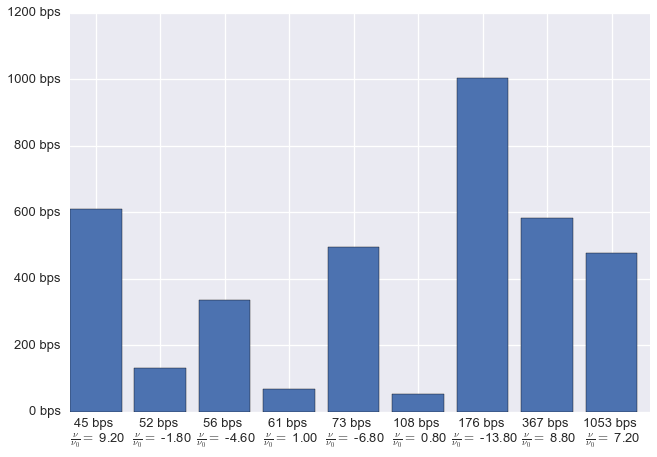

In [16]:
plot_bars(13, color_2_highests=False)

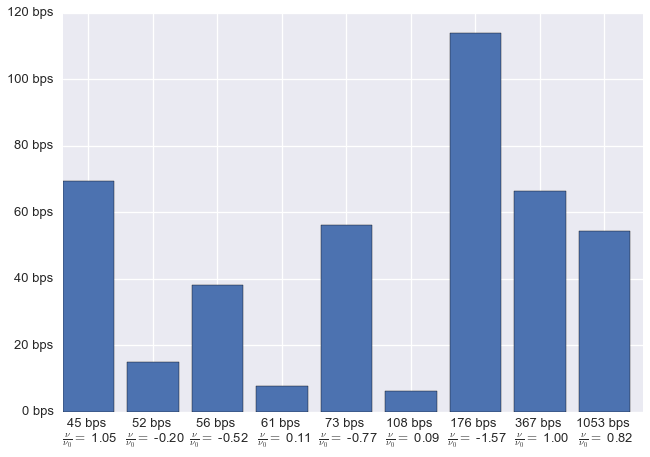

In [17]:
plot_bars(29, color_2_highests=False)